<a href="https://colab.research.google.com/github/HassanFrazKhan/Barclays-Stock-Price-Prediction-Using-Advanced-ML-/blob/main/barclays_stock_pred_Prophat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Necessary Libraries:**

Ensure you have the required libraries installed:

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
from datetime import date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
from prophet.plot import plot_cross_validation_metric





#**Fetching Barclays Stock Data:**
 New section
 The ticker symbol for Barclays on the London Stock Exchange is BARC.L.

In [3]:
# Download Barclays Stock Data
# Define the ticker symbol
ticker_symbol = 'BARC.L'


# Define the date range
start_date = '2014-01-01'
end_date = date.today().strftime('%Y-%m-%d')

# Download historical stock data
barclays_data = yf.download(ticker_symbol, start=start_date, end=end_date, interval='1d')

# Ensure the data is sorted by date
barclays_data.sort_index(inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


#**Calculating Technical Indicators:**

We'll compute the following features using past data (shifted by one day to prevent data leakage):

Moving Averages: 5-day, 10-day, and 50-day moving averages of the closing price.


Daily Returns: Percentage change in the closing price from the previous day.


Volatility: Rolling standard deviation of daily returns over a 10-day window.

In [4]:
# Calculate moving averages (shifted by 1 day)
barclays_data['MA_5'] = barclays_data['Close'].rolling(window=5).mean().shift(1)
barclays_data['MA_10'] = barclays_data['Close'].rolling(window=10).mean().shift(1)
barclays_data['MA_50'] = barclays_data['Close'].rolling(window=50).mean().shift(1)

# Calculate daily returns (shifted by 1 day)
barclays_data['Daily_Returns'] = barclays_data['Close'].pct_change().shift(1) * 100

# Calculate volatility (rolling standard deviation of returns, shifted by 1 day)
barclays_data['Volatility'] = barclays_data['Daily_Returns'].rolling(window=10).std().shift(1)

# Drop rows with NaN values resulting from rolling calculations
barclays_data.dropna(inplace=True)



**Defining Features and Target Variable:**
We'll define our feature set (X) and target variable (y):

In [5]:
# Define features (X) and target variable (y)
X = barclays_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y = barclays_data['Close']


#**Splitting the Data into Training and Testing Sets:**

We'll split the data based on time to create training and testing datasets:

In [6]:
# Split data into training and testing sets
train_data = barclays_data[barclays_data.index < '2023-01-01']
test_data = barclays_data[barclays_data.index >= '2023-01-01']

X_train = train_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_train = train_data['Close']
X_test = test_data[['MA_5', 'MA_10', 'MA_50', 'Daily_Returns', 'Volatility']]
y_test = test_data['Close']

Saving the Datasets to CSV Files:

Finally, we'll save the datasets to CSV files for future use:

In [7]:
# Save datasets to CSV files
train_data.to_csv("barclays_train_data.csv")
test_data.to_csv("barclays_test_data.csv")
X_train.to_csv("barclays_train_features.csv")
y_train.to_csv("barclays_train_target.csv")
X_test.to_csv("barclays_test_features.csv")
y_test.to_csv("barclays_test_target.csv")

In [8]:
# Printing the total number of days and features in the dataset
print('Total number of days present in the dataset:', barclays_data.shape[0])
print('Total number of fields present in the dataset:', barclays_data.shape[1])

Total number of days present in the dataset: 2770
Total number of fields present in the dataset: 10


In [9]:
# Checking the null values
print('Null Values:',barclays_data.isnull().values.sum())
print('NA values:',barclays_data.isnull().values.any())

Null Values: 0
NA values: False


In [10]:
barclays_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2770 entries, 2014-03-13 to 2025-02-27
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (Close, BARC.L)    2770 non-null   float64
 1   (High, BARC.L)     2770 non-null   float64
 2   (Low, BARC.L)      2770 non-null   float64
 3   (Open, BARC.L)     2770 non-null   float64
 4   (Volume, BARC.L)   2770 non-null   int64  
 5   (MA_5, )           2770 non-null   float64
 6   (MA_10, )          2770 non-null   float64
 7   (MA_50, )          2770 non-null   float64
 8   (Daily_Returns, )  2770 non-null   float64
 9   (Volatility, )     2770 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 238.0 KB


In [11]:
barclays_data.head()

Price,Close,High,Low,Open,Volume,MA_5,MA_10,MA_50,Daily_Returns,Volatility
Ticker,BARC.L,BARC.L,BARC.L,BARC.L,BARC.L,,,,,
Date,,,,,,,,,,
2014-03-13,234.928268,239.613886,234.230415,234.778734,64888340,241.966650,246.502711,266.085540,-1.016305,1.490304
2014-03-14,230.442001,237.919029,227.589772,234.878384,73837468,238.447464,244.683301,265.380431,0.812827,1.452708
2014-03-17,230.342392,232.951382,229.245755,231.389179,46130614,235.017990,242.594711,264.549712,-1.909633,1.503701
2014-03-18,235.327057,237.271082,229.494967,231.090073,57727630,232.834705,240.919858,263.624301,-0.043225,1.548831
2014-03-19,240.760345,242.554836,231.454934,237.769534,64501431,232.814764,239.235037,262.729801,2.164024,1.537756


**Flatten the MultiIndex Columns:**

First, we'll flatten the MultiIndex columns to simplify the DataFrame structure.

In [12]:
# Flatten MultiIndex columns
barclays_data.columns = ['_'.join(filter(None, col)).strip() for col in barclays_data.columns.values]

# Display the updated columns
print(barclays_data.columns)


Index(['Close_BARC.L', 'High_BARC.L', 'Low_BARC.L', 'Open_BARC.L',
       'Volume_BARC.L', 'MA_5', 'MA_10', 'MA_50', 'Daily_Returns',
       'Volatility'],
      dtype='object')


Resample the Data:

Next, we'll resample the data to weekly, monthly, and yearly frequencies. For each period, we'll compute the opening price (first value), closing price (last value), highest price, lowest price, and total volume.

In [13]:
# Resample to weekly frequency
barclays_weekly = barclays_data.resample('W').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to monthly frequency
barclays_monthly = barclays_data.resample('M').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})

# Resample to yearly frequency
barclays_yearly = barclays_data.resample('A').agg({
    'Open_BARC.L': 'first',
    'High_BARC.L': 'max',
    'Low_BARC.L': 'min',
    'Close_BARC.L': 'last',
    'Volume_BARC.L': 'sum'
})


# **Plot the Data:**

We'll create subplots to visualize the open and closing prices for daily, weekly, monthly, and yearly data.

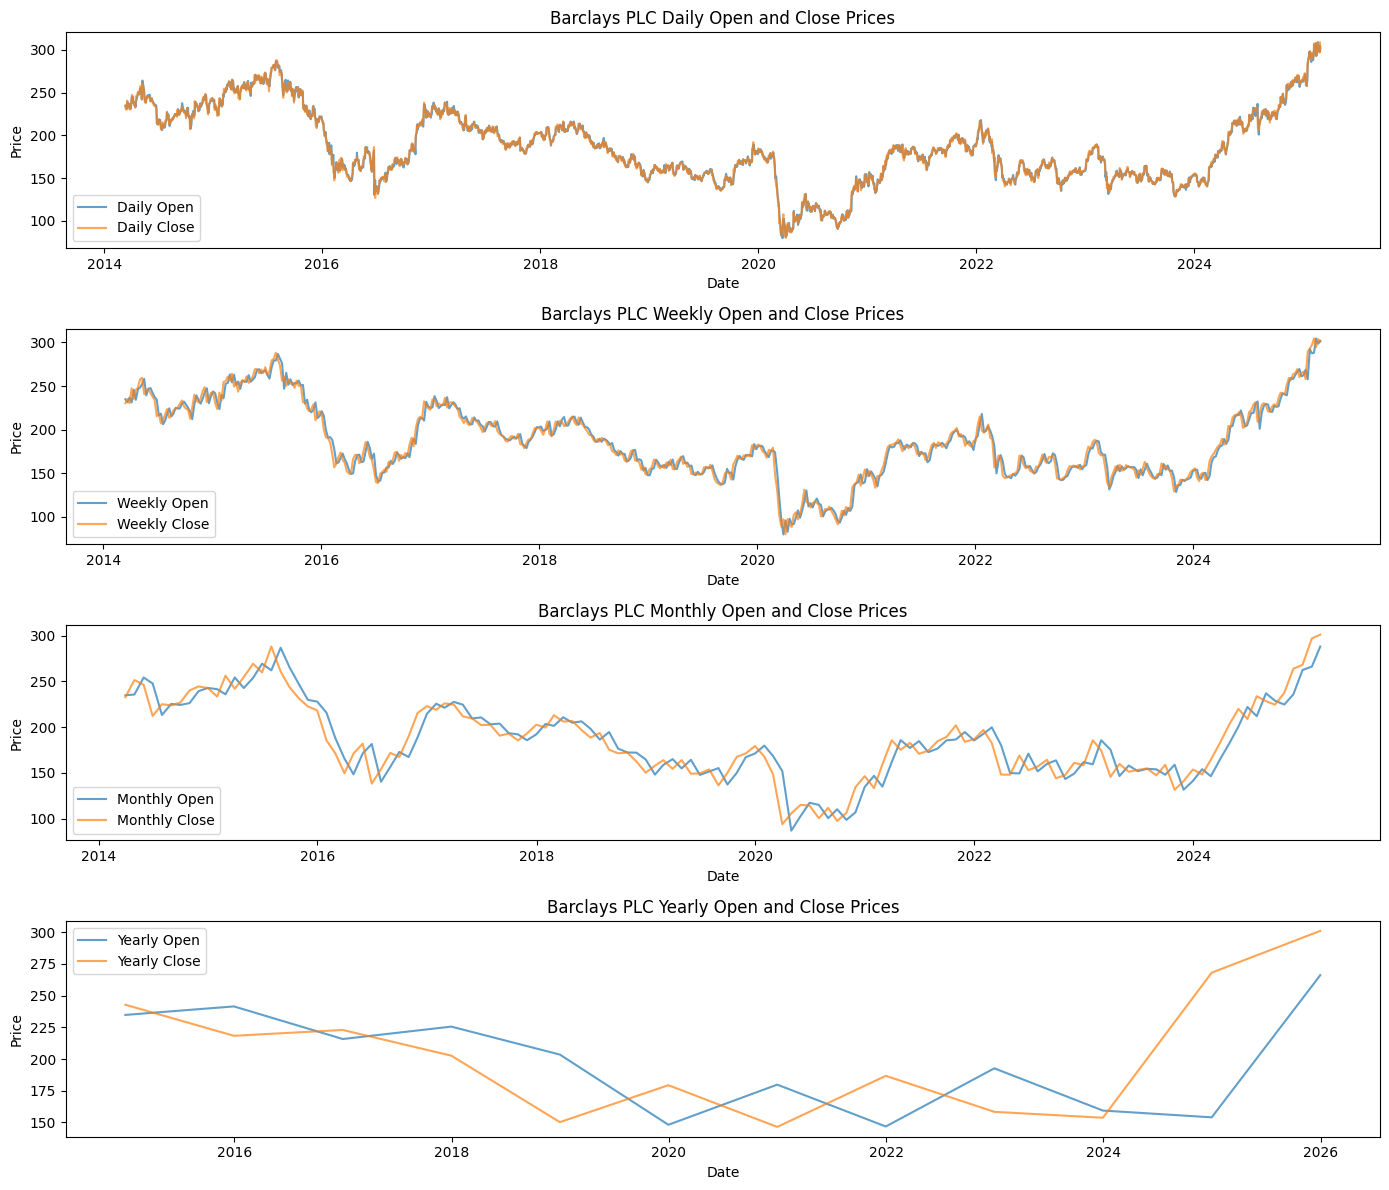

In [14]:

plt.figure(figsize=(14, 12))

# Daily Open and Close Prices
plt.subplot(4, 1, 1)
plt.plot(barclays_data.index, barclays_data['Open_BARC.L'], label='Daily Open', alpha=0.7)
plt.plot(barclays_data.index, barclays_data['Close_BARC.L'], label='Daily Close', alpha=0.7)
plt.title('Barclays PLC Daily Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Weekly Open and Close Prices
plt.subplot(4, 1, 2)
plt.plot(barclays_weekly.index, barclays_weekly['Open_BARC.L'], label='Weekly Open', alpha=0.7)
plt.plot(barclays_weekly.index, barclays_weekly['Close_BARC.L'], label='Weekly Close', alpha=0.7)
plt.title('Barclays PLC Weekly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Monthly Open and Close Prices
plt.subplot(4, 1, 3)
plt.plot(barclays_monthly.index, barclays_monthly['Open_BARC.L'], label='Monthly Open', alpha=0.7)
plt.plot(barclays_monthly.index, barclays_monthly['Close_BARC.L'], label='Monthly Close', alpha=0.7)
plt.title('Barclays PLC Monthly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Yearly Open and Close Prices
plt.subplot(4, 1, 4)
plt.plot(barclays_yearly.index, barclays_yearly['Open_BARC.L'], label='Yearly Open', alpha=0.7)
plt.plot(barclays_yearly.index, barclays_yearly['Close_BARC.L'], label='Yearly Close', alpha=0.7)
plt.title('Barclays PLC Yearly Open and Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


# **Prophat Model**

In [15]:
import pandas as pd
from prophet import Prophet

# --- Verify the flattened column names in test_data ---
print("Columns available in test_data:", test_data.columns)

# Flatten MultiIndex columns
test_data.columns = ['_'.join(filter(None, col)).strip() for col in test_data.columns.values]


# Use string indexing to refer to the desired columns
close_col = 'Close_BARC.L'
open_col = 'Open_BARC.L'

if close_col not in test_data.columns:
    raise KeyError(f"Column {close_col} not found in test_data. Available columns: {test_data.columns}")
if open_col not in test_data.columns:
    raise KeyError(f"Column {open_col} not found in test_data. Available columns: {test_data.columns}")

# Prepare data for Prophet for close price
close_data = barclays_data[['Close_BARC.L']].reset_index()
close_data.rename(columns={'Date': 'ds', 'Close_BARC.L': 'y'}, inplace=True)

# Prepare data for Prophet for open price
open_data = barclays_data[['Open_BARC.L']].reset_index()
open_data.rename(columns={'Date': 'ds', 'Open_BARC.L': 'y'}, inplace=True)



Columns available in test_data: MultiIndex([(        'Close', 'BARC.L'),
            (         'High', 'BARC.L'),
            (          'Low', 'BARC.L'),
            (         'Open', 'BARC.L'),
            (       'Volume', 'BARC.L'),
            (         'MA_5',       ''),
            (        'MA_10',       ''),
            (        'MA_50',       ''),
            ('Daily_Returns',       ''),
            (   'Volatility',       '')],
           names=['Price', 'Ticker'])


In [16]:
# Initialize and fit the Prophet model for Close price
close_model = Prophet(daily_seasonality=True)
close_model.fit(close_data)

# Create a DataFrame for future dates (no extra periods for in-sample forecasting)
close_future = close_model.make_future_dataframe(periods=0)
close_forecast = close_model.predict(close_future)

# Initialize and fit the Prophet model for Open price
open_model = Prophet(daily_seasonality=True)
open_model.fit(open_data)

# Create a DataFrame for future dates (no extra periods for in-sample forecasting)
open_future = open_model.make_future_dataframe(periods=0)
open_forecast = open_model.predict(open_future)


DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0ido0jz/xny0psb0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0ido0jz/o9rllgy5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37873', 'data', 'file=/tmp/tmp_0ido0jz/xny0psb0.json', 'init=/tmp/tmp_0ido0jz/o9rllgy5.json', 'output', 'file=/tmp/tmp_0ido0jz/prophet_modelvig7ulox/prophet_model-20250228004353.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:43:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:43:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0ido0jz/pk5qlall.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0ido0jz/z5xqxtu9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/


Open Price Model Evaluation Metrics:
MSE: 324.4520
RMSE: 18.0126
MAE: 13.9050
R²: 0.8195


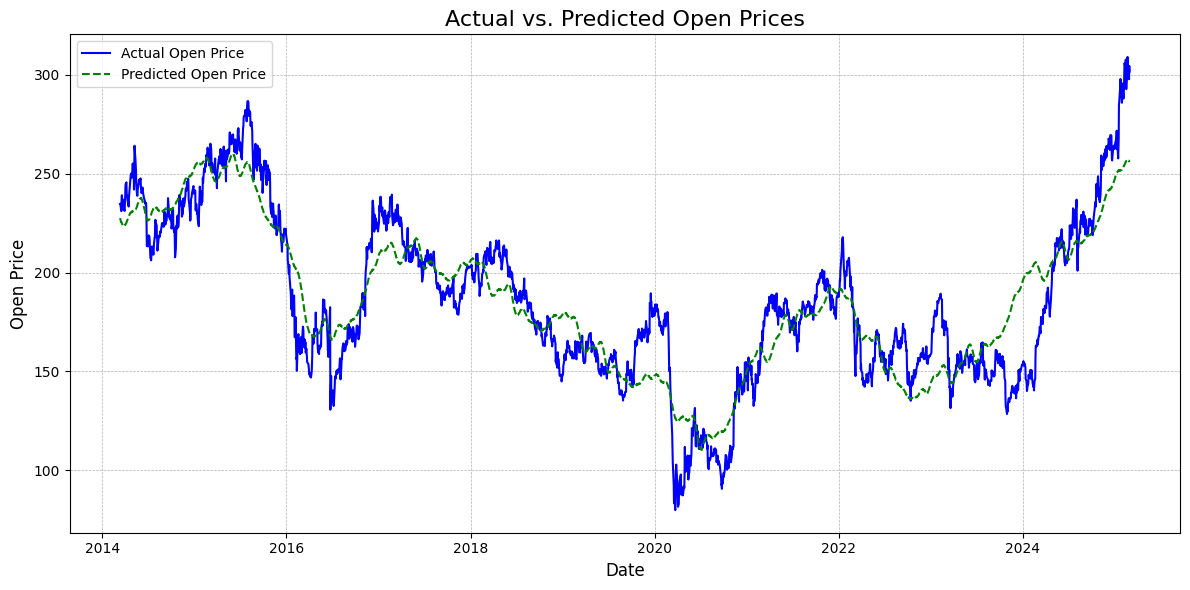

In [17]:
# Merge actual and predicted values for Open price
open_merged = pd.merge(open_data, open_forecast[['ds', 'yhat']], on='ds')

# Calculate metrics for Open price
open_mse = mean_squared_error(open_merged['y'], open_merged['yhat'])
open_rmse = np.sqrt(open_mse)
open_mae = mean_absolute_error(open_merged['y'], open_merged['yhat'])
open_r2 = r2_score(open_merged['y'], open_merged['yhat'])

print("\nOpen Price Model Evaluation Metrics:")
print(f"MSE: {open_mse:.4f}")
print(f"RMSE: {open_rmse:.4f}")
print(f"MAE: {open_mae:.4f}")
print(f"R²: {open_r2:.4f}")


# Plot for Open Price
plt.figure(figsize=(12, 6))
plt.plot(open_merged['ds'], open_merged['y'], label='Actual Open Price', color='blue')
plt.plot(open_merged['ds'], open_merged['yhat'], label='Predicted Open Price', color='green', linestyle='--')
plt.title('Actual vs. Predicted Open Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Open Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



Close Price Model Evaluation Metrics:
MSE: 319.1181
RMSE: 17.8639
MAE: 13.7560
R²: 0.8225


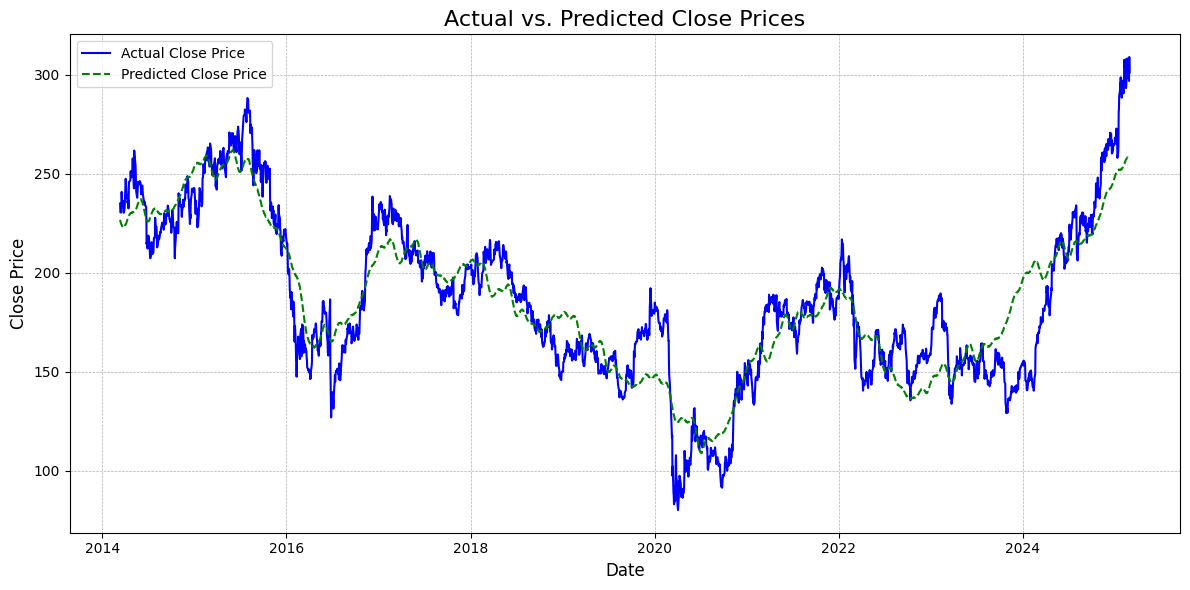

In [18]:
# Merge actual and predicted values for Close price
close_merged = pd.merge(close_data, close_forecast[['ds', 'yhat']], on='ds')

# Calculate metrics for Close price
close_mse = mean_squared_error(close_merged['y'], close_merged['yhat'])
close_rmse = np.sqrt(close_mse)
close_mae = mean_absolute_error(close_merged['y'], close_merged['yhat'])
close_r2 = r2_score(close_merged['y'], close_merged['yhat'])

print("\nClose Price Model Evaluation Metrics:")
print(f"MSE: {close_mse:.4f}")
print(f"RMSE: {close_rmse:.4f}")
print(f"MAE: {close_mae:.4f}")
print(f"R²: {close_r2:.4f}")

# Plot for Close Price
plt.figure(figsize=(12, 6))
plt.plot(close_merged['ds'], close_merged['y'], label='Actual Close Price', color='blue')
plt.plot(close_merged['ds'], close_merged['yhat'], label='Predicted Close Price', color='green', linestyle='--')
plt.title('Actual vs. Predicted Close Prices', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



#  30 Days Plot Future Predictions for Prophet

In [19]:
# Create a DataFrame for future dates (30 days)
open_future = open_model.make_future_dataframe(periods=30)
# Filter the open_future dataframe to include only the future 30 days by removing the current and past days
open_future = open_future[open_future['ds'] > open_data['ds'].max()]
open_forecast = open_model.predict(open_future)


# Initialize and fit the Prophet model for Close price
close_model = Prophet(daily_seasonality=True)
close_model.fit(close_data)

# Create a DataFrame for future dates (30 days)
close_future = close_model.make_future_dataframe(periods=30)
# Filter the close_future dataframe to include only the future 30 days by removing the current and past days
close_future = close_future[close_future['ds'] > close_data['ds'].max()]
close_forecast = close_model.predict(close_future)



DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0ido0jz/prk3jcga.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_0ido0jz/hk788j_3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25758', 'data', 'file=/tmp/tmp_0ido0jz/prk3jcga.json', 'init=/tmp/tmp_0ido0jz/hk788j_3.json', 'output', 'file=/tmp/tmp_0ido0jz/prophet_modelnp5k6wo9/prophet_model-20250228004359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:43:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:44:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


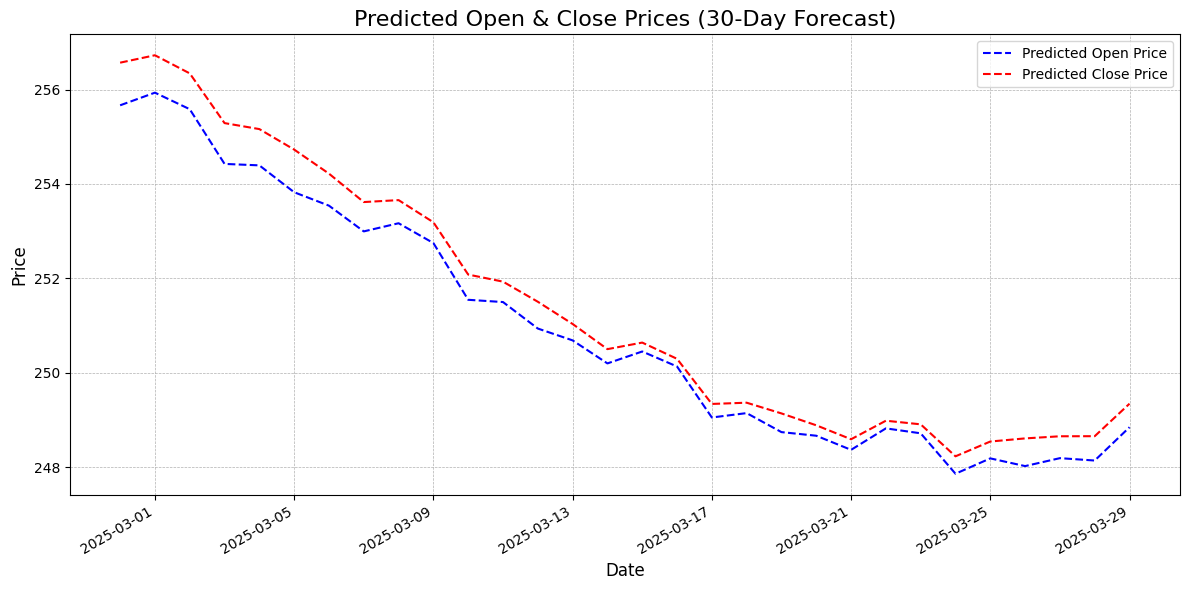

In [20]:
# Merge Open and Close forecasts into a single DataFrame
merged_forecast = pd.merge(open_forecast[['ds', 'yhat']], close_forecast[['ds', 'yhat']], on='ds', suffixes=('_open', '_close'))


# Plotting Open and Close Price forecasts together
plt.figure(figsize=(12, 6))
plt.plot(merged_forecast['ds'], merged_forecast['yhat_open'], label='Predicted Open Price', color='blue', linestyle='--')
plt.plot(merged_forecast['ds'], merged_forecast['yhat_close'], label='Predicted Close Price', color='red', linestyle='--')


# Formatting the plot
plt.title('Predicted Open & Close Prices (30-Day Forecast)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.legend()
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [21]:
# Print the combined forecast table
print("\n30-Day Open and Close Price Forecast:")
print(merged_forecast.tail(30))  # Display the last 30 rows



30-Day Open and Close Price Forecast:
           ds   yhat_open  yhat_close
0  2025-02-28  255.666411  256.570102
1  2025-03-01  255.934602  256.727313
2  2025-03-02  255.584010  256.343155
3  2025-03-03  254.424351  255.289306
4  2025-03-04  254.393515  255.162362
5  2025-03-05  253.823719  254.728162
6  2025-03-06  253.539365  254.218106
7  2025-03-07  252.993952  253.615747
8  2025-03-08  253.166750  253.656919
9  2025-03-09  252.746909  253.187238
10 2025-03-10  251.544217  252.078968
11 2025-03-11  251.496341  251.928931
12 2025-03-12  250.935016  251.502846
13 2025-03-13  250.683932  251.031669
14 2025-03-14  250.195680  250.498209
15 2025-03-15  250.448462  250.637269
16 2025-03-16  250.130231  250.293187
17 2025-03-17  249.049474  249.336715
18 2025-03-18  249.142486  249.362960
19 2025-03-19  248.739575  249.135746
20 2025-03-20  248.662973  248.883976
21 2025-03-21  248.363790  248.588271
22 2025-03-22  248.818735  248.981134
23 2025-03-23  248.714260  248.904505
24 2025-03-